# How to use SLRealzer's own deblend method

In [1]:
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")
from astropy.io import fits
import numpy as np
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


First, define filenames that will become our lens catalog and observation history.

In [2]:
catalog_f = '../data/qso_mock.fits'
observation_f = '../data/twinkles_observation_history.csv'

We make some initial cuts to only work with LSST-like systems.

In [3]:
# Initialize om10
db = om10.DB(catalog=catalog_f)
# Select LSST-like lenses by querying with these values
# TODO make the values globally configurable
db.select_random(maglim=22.5, area=18000.0, IQ=0.75)
# Calculate the synthetic magnitude for the OM10 catalog -- need this
db.paint(synthetic=True)
# Calculate the sizes for the OM10 catalog -- if you want to assume the point-source-like-galaxies, get rid of this
#db.calculate_size()

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 1634 lenses


In [4]:
# Initialize SLRealizer with OM10 lens systems and Twinkles observations
realizer = desc.slrealizer.SLRealizer(catalog=db, observation=observation_f)

Now we would like to make further cuts to choose particularly good (bright and well-separated) lens systems that consist of two (doubles) or four (quads) objects. To do this, first access the column names of the FITS file (the mock lens catalog), and then select desired systems in numpy.

In [12]:
print fits.getdata(catalog_f).columns

ColDefs(
    name = 'LENSID'; format = 'J'
    name = 'FLAGTYPE'; format = 'I'
    name = 'NIMG'; format = 'I'
    name = 'ZLENS'; format = 'D'
    name = 'VELDISP'; format = 'D'
    name = 'ELLIP'; format = 'D'
    name = 'PHIE'; format = 'D'
    name = 'GAMMA'; format = 'D'
    name = 'PHIG'; format = 'D'
    name = 'ZSRC'; format = 'D'
    name = 'XSRC'; format = 'D'
    name = 'YSRC'; format = 'D'
    name = 'MAGI_IN'; format = 'D'
    name = 'MAGI'; format = 'D'
    name = 'IMSEP'; format = 'D'
    name = 'XIMG'; format = '4D'
    name = 'YIMG'; format = '4D'
    name = 'MAG'; format = '4D'
    name = 'DELAY'; format = '4D'
    name = 'KAPPA'; format = '4D'
    name = 'FSTAR'; format = '4D'
    name = 'DD'; format = 'D'
    name = 'DDLUM'; format = 'D'
    name = 'ABMAG_I'; format = 'D'
    name = 'APMAG_I'; format = 'D'
    name = 'KCORR'; format = 'D'
    name = 'DS'; format = 'D'
    name = 'DDS'; format = 'D'
    name = 'SIGCRIT'; format = 'D'
    name = 'DSLUM'; format = 'D'


In [13]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

#wide_quads = wide[np.where(wide['NIMG'] == 4)]
wide_quads = wide[np.where(np.logical_or(wide['NIMG'] == 4, wide['NIMG'] ==2))]
print "Number of these with 2 or 4 images = ",len(wide_quads)

bright_wide_quads = wide_quads[np.where(wide_quads['MAGI'] < 22.5)]
print "Number of these with i3 < 22.5 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
#k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  20
Number of these with 2 or 4 images =  20
Number of these with i3 < 22.5 =  20


Here is what the observation history table looks like, if you are curious:

In [16]:
import pandas as pd
obs_example = pd.read_csv(observation_f, index_col=0).head()
obs_example

,expMJD,filter,FWHMeff,fiveSigmaDepth
obsHistID,,,,
183767,59823.286523,g,1.093153,24.377204
183811,59823.307264,g,1.231930,24.289872
184047,59823.418685,z,0.908511,21.923566
185595,59825.256044,r,0.949096,24.128617
185736,59825.325979,g,1.242407,24.316968


Now we are ready to use SLRealizer to visualize the lens system. In the following cell, we take the first system (`lens_idx = 0`). First, we visualize the system by drawing each object of the system based on the catalog information and overlaying them on on a pixelated canvas -- this is the "BEFORE DEBLENDING" image. Then, after numerically obtaining the flux, position, size, and ellipticity of this image, we draw the system purely from the numerically derived parameters, yielding the "AFTER DEBLENDING" image.

OM10: selection yields 20 lenses
OM10: Extracted OM10 lens number 70455207:
 LENSID  FLAGTYPE NIMG ... i_SDSS_quasar   z_SDSS_quasar      u_SDSS_quasar   
-------- -------- ---- ... ------------- ------------------ ------------------
70455207        0    4 ...         23.47 23.435099063499585 27.143209257670268
OM10: Extracted OM10 lens number 70455207:
 LENSID  FLAGTYPE NIMG ... i_SDSS_quasar   z_SDSS_quasar      u_SDSS_quasar   
-------- -------- ---- ... ------------- ------------------ ------------------
70455207        0    4 ...         23.47 23.435099063499585 27.143209257670268


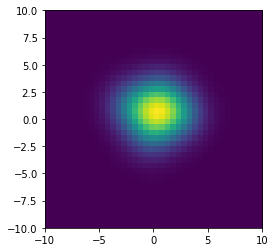

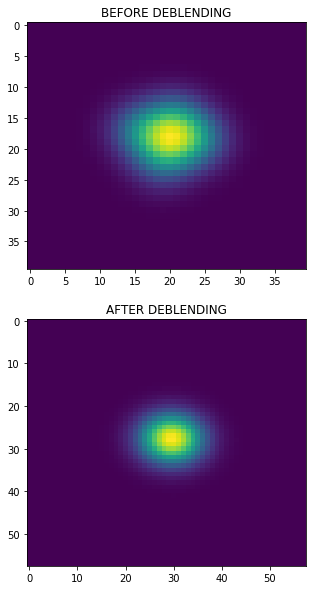

In [9]:
lens_idx = 0
params = realizer.plot_lens_random_date(lensID=db.sample[lens_idx]['LENSID'])

The numerically derived parameters are stored in a dictionary called `params`. Let's take a look at its contents:

In [17]:
params

{'DEC': 0,
 'DEC_err': 0,
 'MJD': 59926.1555,
 'PSF_HWHM': 0.620962,
 'RA': 0,
 'RA_err': 0,
 'band': 'r',
 'e': 0.12269188138198514,
 'first_moment_x': 0.20240761943568517,
 'first_moment_x_err_calc': 0,
 'first_moment_y': -0.16578034745334247,
 'first_moment_y_err_calc': 0,
 'flux': 9.113169184080892,
 'flux_err_calc': 0.03349746913784146,
 'lensID': 70455207,
 'phi': galsim.Angle(0.0746858643046197, galsim.radians),
 'size': 0.8451016582163033,
 'size_err': 0,
 'sky_mag': 24.440045}